# Decision Tree Classifier Notebook
### Author: Krzysztof Chmielewski

This notebook implements a decision tree classifier from scratch and evaluates it on the `diabetes.csv` dataset. It demonstrates:
- Data loading and exploratory analysis (class distribution)
- Decision tree algorithm (entropy, information gain, recursive splitting)
- Model implementation (node structure, tree building, prediction)
- Training and evaluation (precision, recall, F1, confusion matrix)

## Model Purpose and Applications

**Decision Trees** are intuitive **tree-structured models** for both classification and regression. They recursively split data to create interpretable decision rules, making them valuable for understanding "why" a prediction was made.

### Key Use Cases:
- **Medical diagnosis**: Creating diagnostic decision rules for doctors
- **Loan approval**: Building explainable credit decision systems
- **Customer segmentation**: Partitioning customers for marketing strategies
- **Feature importance analysis**: Identifying which features matter most
- **Risk assessment**: Creating interpretable risk classification systems
- **Manufacturing quality control**: Decision trees for defect detection
- **Regulatory compliance**: Providing audit trails for decisions

### Strengths:
- **Highly interpretable** — easy to visualize and explain to non-technical stakeholders
- Handles both classification and regression
- No feature scaling required
- Can capture non-linear relationships
- Requires minimal data preprocessing
- Fast prediction time

### Limitations:
- Prone to **overfitting** without depth/sample constraints
- Unstable — small data changes cause large tree changes
- Biased toward features with many values
- Can create imbalanced trees with imbalanced classes
- Greedy splitting (not globally optimal)

In [39]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.evaluation import eval_model

In [40]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return -np.sum(p * np.log2(p + 1e-12))   # add epsilon for numerical safety

def split_dataset(X, y, feature, threshold):
    left_mask  = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold

    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

## Decision Tree: Core Concepts

A decision tree recursively splits data using the **information gain** criterion to build a tree structure for classification.

### Entropy

Entropy measures the impurity or disorder in a set of labels:

$$H(y) = -\sum_{c=1}^{C} p_c \log_2(p_c)$$

where $p_c$ is the proportion of class $c$ in the sample. Entropy ranges from 0 (pure, single class) to 1 (maximum disorder).

### Information Gain

Information gain measures how much a split reduces entropy:

$$IG = H(y) - \left[ \frac{n_{left}}{n} H(y_{left}) + \frac{n_{right}}{n} H(y_{right}) \right]$$

where $n_{left}$, $n_{right}$ are the sizes of left and right child nodes after splitting.

The algorithm greedily selects splits that maximize information gain to recursively build the tree, stopping at:
- Maximum depth (`max_depth`)
- Minimum samples required to split (`min_samples_split`)
- Pure nodes (single class)

In [59]:
class DecisionTree:
    def __init__(self, max_depth = 5, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value  # used for leaf nodes

    def __most_common_label(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def __best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_info_gain = -1

        current_entropy = entropy(y)
        n_samples, n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                _, y_left, _, y_right = split_dataset(X, y, feature, threshold)

                if len(y_left) == 0 or len(y_right) == 0: continue

                left_entropy = entropy(y_left)
                right_entropy = entropy(y_right)

                child_entropy = (
                    len(y_left)/n_samples * left_entropy +
                    len(y_right)/n_samples * right_entropy
                )

                info_gain = current_entropy - child_entropy

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_info_gain
    
    def __build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        num_classes = len(np.unique(y))

        if (depth >= self.max_depth or n_samples < self.min_samples_split or num_classes == 1):
            leaf_value = self.__most_common_label(y)
            return self.Node(value=leaf_value)
        
        feature, threshold, gain = self.__best_split(X, y)

        if gain <= 0:
            return self.Node(value=self.__most_common_label(y))
        
        X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)

        # recursively find best split and build left and right subtree
        left_child = self.__build_tree(X_left, y_left, depth+1)
        right_child = self.__build_tree(X_right, y_right, depth+1)
        
        return self.Node(feature, threshold, left_child, right_child)
    
    def __predict_sample(self, x, node: Node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self.__predict_sample(x, node.left)
        else:
            return self.__predict_sample(x, node.right)
        
    def plot_tree(self):
        G = nx.DiGraph()

        def add_nodes_edges(node, parent=None, edge_label=""):
            if node is None:
                return
            
            # label node
            if node.value is not None:
                label = f"Leaf\nClass={node.value}"
            else:
                label = f"X[{node.feature}] <= {node.threshold:.3f}"

            G.add_node(id(node), label=label)

            # connect to parent
            if parent is not None:
                G.add_edge(id(parent), id(node), label=edge_label)

            # recursively add children
            if node.left:
                add_nodes_edges(node.left, node, "True")
            if node.right:
                add_nodes_edges(node.right, node, "False")

        add_nodes_edges(self.root)

        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

        nx.draw(G, pos, with_labels=False, arrows=True)

        plt.show()

    
    def fit(self, X, y):
        self.root = self.__build_tree(X, y)

    def predict(self, X):
        return np.array([self.__predict_sample(x, self.root) for x in X])

## Dataset

We use the `data/diabetes.csv` dataset. The dataset contains clinical measurements for patients and a binary target column named `Outcome` (1 = diabetes, 0 = no diabetes). When we load the file, we inspect the first rows and dataset shape to confirm correct loading.

In [42]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [43]:
# split data into X and Y
X = data.drop("Outcome", axis=1).values
Y = data["Outcome"].values.reshape(-1,1)

print(f'X shape: {X.shape}\nY shape: {Y.shape}')

X shape: (768, 8)
Y shape: (768, 1)


## Class Distribution

Decision trees can handle imbalanced datasets relatively well, but it is important to visualize the class balance. We plot the proportion of negative (0) and positive (1) samples. If the classes are highly imbalanced, stratified train/test splitting is recommended to ensure both train and test sets have similar class distributions.

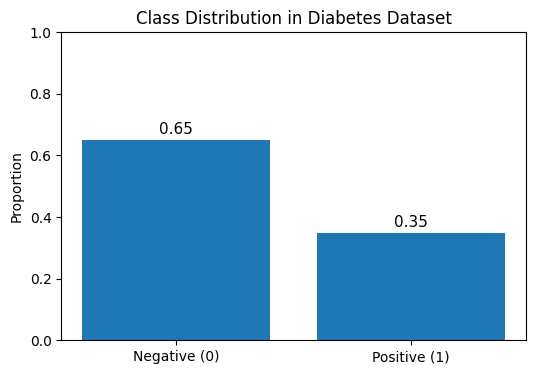

In [44]:
positive = np.count_nonzero(Y)
negative = len(Y) - positive

values = [negative / len(Y), positive / len(Y)]
labels = ["Negative (0)", "Positive (1)"]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)  # use text labels instead of indices

plt.title("Class Distribution in Diabetes Dataset")
plt.ylabel("Proportion")
plt.ylim(0, 1)

# add values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=11)

plt.show()

In [60]:
# split X and Y into train and test with stratification for unbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# create model object and fit train data
DT = DecisionTree(max_depth=10)
DT.fit(X_train, y_train)

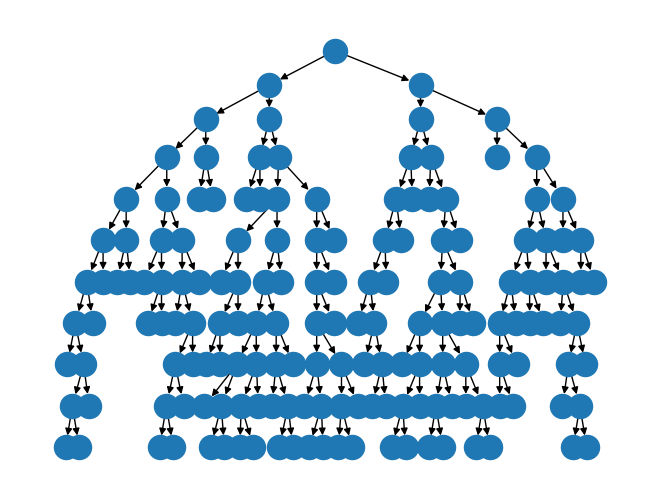

In [61]:
DT.plot_tree()

## Evaluation

After training, we predict class labels on the test set and evaluate using common classification metrics:

- **Precision**: proportion of predicted positives that are correct — $\frac{TP}{TP + FP}$
- **Recall**: proportion of actual positives that are found — $\frac{TP}{TP + FN}$
- **F1 score**: harmonic mean of precision and recall — $2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$

We use the local helper `eval_model(y_true, y_pred)` to compute and display these metrics and the confusion matrix.

In [30]:
# predict values on test data
y_pred = DT.predict(X_test)

# evaluate logistic regression model with precision, recall and f1 score
eval_model(y_test, y_pred);

Precision: 0.3506
Recall: 0.3463
F1: 0.3485
